In [1]:
#
# Copyright 2018-2019 IBM Corp. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Nucleus Segmenter Example
In this example, we show how the MAX-Nucleus-Segmenter model can be used to detect and visualize the nuclei from a microscopy image.

## Contents of this demo
We first visualize the microscopy image and pass it through the MAX-Nucleus-Segmenter model to get the masks for the detected nuclei in a JSON format. We then visualize the detected nuclei to verify that the model worked as intended. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import skimage.color
import skimage.io
import skimage.transform
import requests
import json

input_img_file = 'assets/example.png'
org_img = skimage.io.imread(input_img_file)

## Visualize the test image

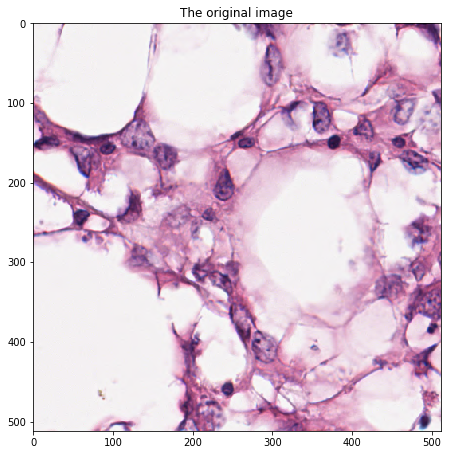

In [2]:
fig = plt.figure()
fig.set_size_inches(10, 7.5)
plt.title("The original image")
plt.imshow(org_img)
plt.show()

## Detect the nuclei from the test image

In [3]:
url = 'http://localhost:5000/model/predict'

# Submit the nuclei detection request by calling the rest API
def get_nuclei(input_img):
    """
    Takes in input image file path and detects poses.
    """
    files = {'image': ('image.jpg',open(input_img,'rb'), 'images/jpeg')}
    result = requests.post(url, files=files).json()
    
    return result

In [ ]:
# Submit the rest request and print out the JSON result
preds = get_nuclei(input_img_file)
print(json.dumps(preds, indent=2))

## Visualize the detected nuclei

In [5]:
from core.mask_rcnn.mrcnn.visualize import random_colors, apply_mask

# Decodes the RLE encoded mask to a binary mask  
def rle_decode(rle, shape):
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask

def visualize(masks, image):
    figsize=(8, 8) 
    _, ax = plt.subplots(1, figsize=figsize)
        
    colors = random_colors(len(masks))
    
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title("Detected Nuclei")
    
    masked_image = image.astype(np.uint32).copy()
    for i in range(len(masks)):
        mask = masks[i]
        color = colors[i]
        masked_image = apply_mask(masked_image, mask, color)
    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


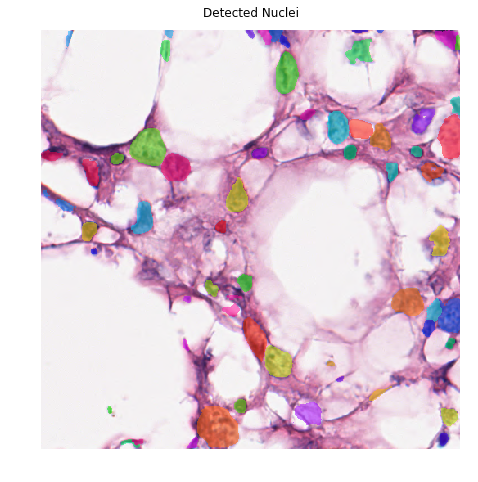

In [6]:
results = preds["predictions"]
masks = []

# Decodes the RLE encoded masks to the binary masks
for result in results:
    mask = result["mask"]
    masks.append(rle_decode(mask, org_img.shape[0:2]))
# Visualize the detected nuclei on the input image    
visualize(masks, org_img)